In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import Counter
import math
from functools import partial
from tqdm import tqdm
from p_tqdm import p_map, p_umap, p_imap, p_uimap
from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import Process
import time
plt.style.use('ggplot')


In [2]:
# Check if utilities class is imported successfully
import sys
import utilities 

modulename = 'utilities'
if modulename not in sys.modules:
    print('import not successful!')

In [3]:
df = pd.read_csv('cat_w_noise.csv')
df

,x,y,class
0,11,158,0
1,12,160,0
2,14,156,0
3,15,156,0
4,16,160,0
...,...,...,...
3683,426,164,0
3684,426,217,0
3685,426,358,0
3686,426,370,0


<Axes: xlabel='x', ylabel='y'>

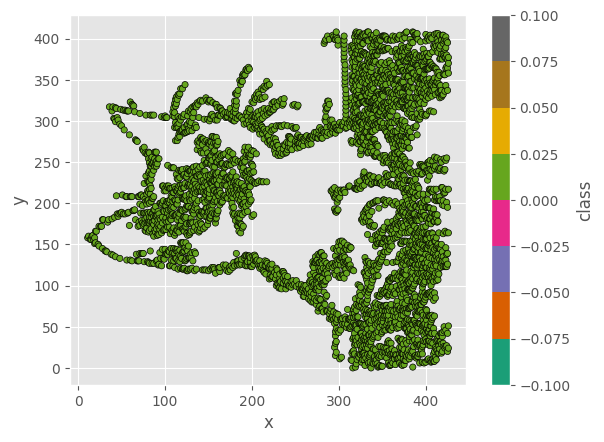

In [4]:
df.plot(x= 'x', y = 'y', c='class', kind= 'scatter', colormap= 'Dark2', edgecolor='k')

In [5]:
n = 20
K = 1

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 
P = df.to_numpy() 
print(f'Dataset of target classifier: {P.shape}')

Dataset of target classifier: (3688, 3)


In [6]:
# This function implements the Knn classifier by computing the euclidean distance between data points
def knn(k, predicted_x, predicted_y, pool):
    
    predicted_dp = np.array([predicted_x, predicted_y, 0.0])
    distances = predicted_dp - pool
    distances = np.power(distances, 2)
    distances = distances[:,0:2] 
    distances = np.sum(distances, axis=1)
    distances = np.sqrt(distances)
    
    vote_pool_indices = np.argsort(distances)[:k]
    vote_pool_classes = [pool[i][2] for i in vote_pool_indices]
    vote_result = Counter(vote_pool_classes).most_common()
    
    return vote_result[0][0]

In [7]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[0:1:15j,0:1:15j]

# We precompute and store target classifier to avoid recomputation
target_class_mesh = []
# for i in range(len(mesh_X)):
#     res = []
#     for j in range(len(mesh_X[0])):
#         res.append(knn(K, mesh_X[i][j], mesh_Y[i][j], P))
        
#     target_class_mesh.append(res)

for dp in P[:, :2]:
    res = knn(K, dp[0], dp[1], P)
    target_class_mesh.append(res)
    
target_class_mesh = np.array(target_class_mesh)

In [8]:
import random
random.seed(10)


# Greedy
def greedy(n_stop):
    max_N = n_stop # Size of desired teaching set
    util_obj = utilities.Utilities(max_N, K, mesh_X, mesh_Y, P, target_class_mesh)
    
    start = time.time()
    cost = 0
    best_teaching_cost = math.inf 
    curr_best_teaching_cost = math.inf 
    curr_best_teaching_set = np.array([])
    best_teaching_set = np.array([])
    searched_teaching_set_size = 0
    
    copy_P = np.copy(P)
    # Randomly pick a data point to make the teaching set's size = 1.
    idx = random.randint(0, len(copy_P)-1) 
    # Iterate over each point in the pool, and store the data point that yields the smallest disagreement function value into the teaching set   
   
    curr_D = np.array([copy_P[idx]])
    while not np.isinf(cost):
        curr_temp_best_teaching_cost = math.inf
        removed_idx = 0
        for i in range(len(copy_P)):
            searched_teaching_set_size += 1
            temp_D = np.append(curr_D, np.array([copy_P[i]]), axis=0)
            data = util_obj.disagreement_func_ex(temp_D)
            cost = data[0]
            if np.isinf(cost):
                break
            
            if cost < curr_temp_best_teaching_cost:
                curr_best_teaching_cost = cost
                curr_temp_best_teaching_cost = cost
                curr_best_teaching_set = temp_D 
                removed_idx = i
                
            if cost < best_teaching_cost:
                best_teaching_cost = cost
                best_teaching_set = temp_D 
       
        if not np.isinf(cost):
            curr_D = curr_best_teaching_set
            copy_P = np.delete(copy_P, removed_idx, axis=0)
        # print(curr_best_teaching_cost, len(curr_best_teaching_set))
   
    end = time.time()
    total_time = end - start 
    
    return curr_best_teaching_set, curr_best_teaching_cost, searched_teaching_set_size, total_time



In [9]:
def analyze_greedy(n_stop):
    list_best_teaching_set = [] 
    list_best_teaching_cost = [] 
    list_number_of_teaching_sets = [] 
    list_total_time = [] 
    for n in tqdm(range(2, n_stop+1)):
        best_teaching_set, best_teaching_cost, number_of_teaching_sets, total_time = greedy(n) 
        list_best_teaching_set.append(best_teaching_set)
        list_best_teaching_cost.append(best_teaching_cost)
        list_number_of_teaching_sets.append(number_of_teaching_sets)
        list_total_time.append(total_time)
        
    return list_best_teaching_set, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time
    

In [10]:
def print_analyze_greedy(n_stop, style, teaching_colors):
    
    list_best_teaching_sets, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time = analyze_greedy(n_stop)
  
    ts_size = 2
    for best_teaching_set in list_best_teaching_sets:
        fig, ax = plt.subplots()
        ax.set_title(f'Greedy: Teaching set data points $n$ = {ts_size} (random restarts)')
        ax.scatter(temp_P[0], temp_P[1], c=temp_P[2], cmap=style, s=20, alpha= 0.7)
        ts = best_teaching_set.T
        # plt.scatter(ts[0], ts[1], c= [teaching_colors[color] for color in ts[2]], edgecolor='k')
        size_order = 20 
        for dp in best_teaching_set:
            ax.scatter(dp[0], dp[1], c= teaching_colors[int(dp[2])], edgecolor='k', label= dp[2], s= size_order)
            size_order+= 5
           
        ax.legend(bbox_to_anchor = (1, 1), title= "Increasing size with each addition of teaching items")
        plt.show()
        ts_size += 1
    
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs disagreement function cost')
    plt.xlabel('New teaching set size')
    plt.ylabel('Disagreement function cost')
    plt.plot(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.scatter(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.show()
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs searched teaching set size')
    plt.xlabel('New teaching set size')
    plt.ylabel('Searched teaching set size')
    plt.plot(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.scatter(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.show()
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs time elapsed (s)')
    plt.xlabel('New teaching set size')
    plt.ylabel('Time elapsed (s)')
    plt.plot(range(2, len(list_total_time)+2), list_total_time)
    plt.scatter(range(2, len(list_total_time)+2), list_total_time)
    plt.show()

In [11]:
teaching_colors = {0: 'yellow'}
print_analyze_greedy(20, 'Dark2', teaching_colors)

  5%|█▉                                   | 1/19 [03:02<54:47, 182.61s/it]


KeyboardInterrupt: 